In [1]:
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import imageio
import cv2

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# open zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/rawData.zip', 'r')

# create folder with raw data
zip_ref.extractall('/content/BloodCellData')
zip_ref.close()

In [6]:
# Train Data Directory
Train_datadir = '../content/BloodCellData/Data/Train'
Test_datadir = '../content/BloodCellData/Data/Test'

print("Train Directory Folders:", os.listdir(Train_datadir))
print("Test Directory Folders:", os.listdir(Test_datadir))

Train Directory Folders: ['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
Test Directory Folders: ['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']


In [7]:
# Image Size
image_width = 320
image_height = 240

# Split the data to training
train_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    label_mode='int',
    validation_split=0.3,
    subset="training",
    seed=321,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the data to validation
validation_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    label_mode='int',
    validation_split=0.3,
    subset="validation",
    seed=321,
    shuffle=True,
    image_size=(image_height, image_width))

Found 9957 files belonging to 4 classes.
Using 6970 files for training.
Found 9957 files belonging to 4 classes.
Using 2987 files for validation.


In [8]:
class_names = train_images.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


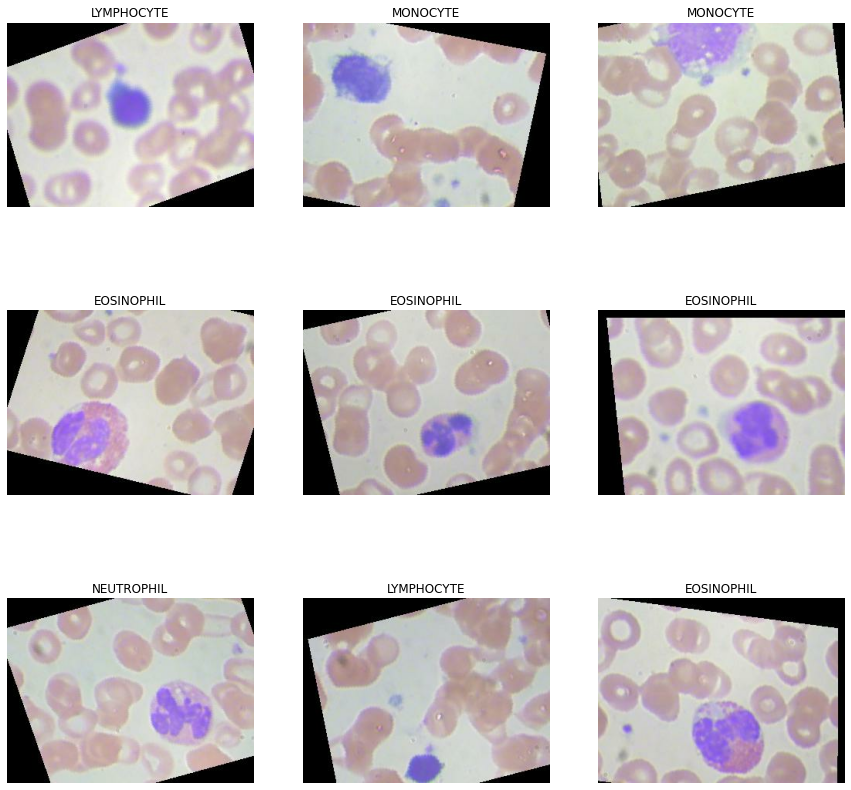

In [11]:
# Display images from train_image split
plt.figure(figsize=(15, 15))

for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# Display shape of the batches from the train_image split
for image_batch, labels_batch in train_images:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 320, 3)
(32,)


In [ ]:
'''
Old model notes / layers

x = base_model(x, training=False)
x = tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Dropout(.25)(x)
x = tf.keras.layers.Conv2D(128,(2,2),activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Dropout(.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)
'''

In [15]:
# Using transfer learning base model Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(240, 320, 3),
    include_top=False
)

# Freezing base_model
base_model.trainable = False

# Input variable
inputs = tf.keras.Input(shape=(240, 320, 3))

# Rescales using Xception preprocessing to (-1,1)
x = tf.keras.applications.xception.preprocess_input(inputs)

# Build base model
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 240, 320, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 240, 320, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
initial_epochs = 20
history = model.fit(train_images, 
                    epochs=initial_epochs, 
                    validation_data=validation_images)

Epoch 1/20
218/218 [==============================] - 48s 195ms/step - loss: 1.2359 - accuracy: 0.4310 - val_loss: 1.1138 - val_accuracy: 0.5343
Epoch 2/20
218/218 [==============================] - 41s 189ms/step - loss: 1.0765 - accuracy: 0.5453 - val_loss: 1.0297 - val_accuracy: 0.5661
Epoch 3/20
218/218 [==============================] - 42s 190ms/step - loss: 1.0068 - accuracy: 0.5753 - val_loss: 0.9801 - val_accuracy: 0.5942
Epoch 4/20
218/218 [==============================] - 42s 189ms/step - loss: 0.9610 - accuracy: 0.6082 - val_loss: 0.9310 - val_accuracy: 0.6307
Epoch 5/20
218/218 [==============================] - 41s 189ms/step - loss: 0.9150 - accuracy: 0.6333 - val_loss: 0.9141 - val_accuracy: 0.6197
Epoch 6/20
218/218 [==============================] - 42s 190ms/step - loss: 0.8991 - accuracy: 0.6291 - val_loss: 0.8984 - val_accuracy: 0.6224
Epoch 7/20
218/218 [==============================] - 42s 190ms/step - loss: 0.8779 - accuracy: 0.6496 - val_loss: 0.8648 - val_ac

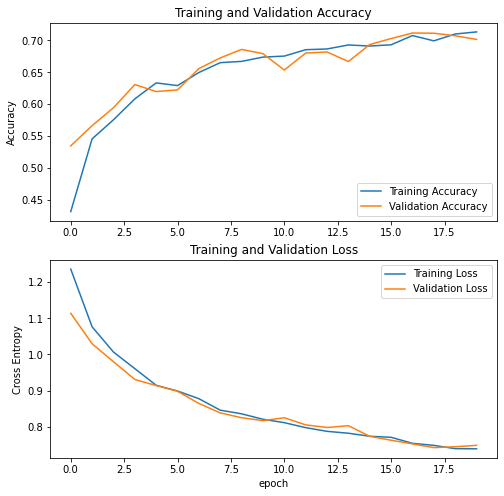

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
test_images = tf.keras.utils.image_dataset_from_directory(
    Test_datadir,
    label_mode='int',
    shuffle=True,
    image_size=(image_height, image_width))

Found 2487 files belonging to 4 classes.


In [23]:
loss, accuracy = model.evaluate(test_images)
print("Loss:", loss)
print("Accuracy:", accuracy)

78/78 [==============================] - 11s 136ms/step - loss: 1.2908 - accuracy: 0.4729
Loss: 1.2908284664154053
Accuracy: 0.47285887598991394


In [24]:
# Unfreezing the Entire Model and training at a very low rate

base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 240, 320, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 240, 320, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [25]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history2 = model.fit(train_images, 
                     epochs=total_epochs,
                     initial_epoch=history.epoch[-1],
                     validation_data=validation_images)

Epoch 20/30
218/218 [==============================] - 161s 710ms/step - loss: 0.4499 - accuracy: 0.8254 - val_loss: 0.2257 - val_accuracy: 0.9263
Epoch 21/30
218/218 [==============================] - 153s 703ms/step - loss: 0.1370 - accuracy: 0.9463 - val_loss: 0.0920 - val_accuracy: 0.9675
Epoch 22/30
218/218 [==============================] - 154s 704ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.0507 - val_accuracy: 0.9826
Epoch 23/30
218/218 [==============================] - 154s 704ms/step - loss: 0.0219 - accuracy: 0.9950 - val_loss: 0.0363 - val_accuracy: 0.9886
Epoch 24/30
218/218 [==============================] - 154s 704ms/step - loss: 0.0114 - accuracy: 0.9976 - val_loss: 0.0246 - val_accuracy: 0.9926
Epoch 25/30
218/218 [==============================] - 153s 703ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0456 - val_accuracy: 0.9826
Epoch 26/30
218/218 [==============================] - 154s 704ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0

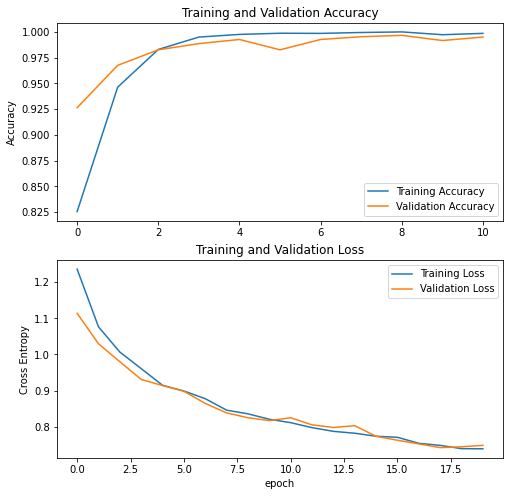

In [30]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
loss, accuracy = model.evaluate(test_images)
print("Loss:", loss)
print("Accuracy:", accuracy)

78/78 [==============================] - 11s 133ms/step - loss: 1.9246 - accuracy: 0.7250
Loss: 1.9245541095733643
Accuracy: 0.7249698638916016


In [ ]:
# Below are just random snippets and notes

In [ ]:
Prediction = model.predict(test_images)
Prediction = Prediction.argmax(axis=1)

In [ ]:
print(Prediction)

In [ ]:
labelList = []

for batch in range(len(test_images)):
  for img, label in test_images.take(batch):
    labelList.append(label)

In [ ]:
list(labelList[1])

In [ ]:
flat_list[:5]

In [ ]:
# Display images from train_image split
plt.figure(figsize=(15, 15))

for images, labels in test_images.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")